# PyTorch Basics

I'll assume that everyone is familiar with python. Training neural nets in bare python is somewhat painful, but fortunately there are several well-established libraries which can help. I like pytorch, which is built upon an earlier library called torch. There are many others, including TensorFlow and Jax.

In [54]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torchvision

In [55]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.15712112 0.74391533 0.83364516]
 [0.73384515 0.08844869 0.51282697]]
tensor([[0.1571, 0.7439, 0.8336],
        [0.7338, 0.0884, 0.5128]], dtype=torch.float64)


In [56]:
print(b + 10.0)
print()
print(torch.sin(b))
print()
print(b.sum())
print()
print(b.mean())
print()
print(b.shape)

tensor([[10.1571, 10.7439, 10.8336],
        [10.7338, 10.0884, 10.5128]], dtype=torch.float64)

tensor([[0.1565, 0.6772, 0.7404],
        [0.6697, 0.0883, 0.4906]], dtype=torch.float64)

tensor(3.0698, dtype=torch.float64)

tensor(0.5116, dtype=torch.float64)

torch.Size([2, 3])


Torch believes everything is a *tensor.*

The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that training neural nets basically consits of *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about torch variables is that they (natively) can be differentiated. Again, we'll see why this is important when we learn about backpropagation.

Suppose we want $dy/da$ in the following expression:
- $y = a + b$

In [57]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = a + b
print("a:", a)
print("b:", b)
print("y:", y)

a: tensor([[0.7476]], requires_grad=True)
b: tensor([[0.4284]])
y: tensor([[1.1760]], grad_fn=<AddBackward0>)


Here, $y$ is a function of the input $a$ so we can use PyTorch to compute $dy/da$

In [58]:
y.backward()
print("dy/da:", a.grad)

dy/da: tensor([[1.]])


Let's try this again with a more complex function:
- $y = a^2 \cdot b$



In [59]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = (a**2)*b
print("a:", a)
print("b:", b)
print("y:", y)
y.backward()
print("dy/da:", a.grad)
print("dy/da:", 2 * a * b)

a: tensor([[0.1356]], requires_grad=True)
b: tensor([[0.5041]])
y: tensor([[0.0093]], grad_fn=<MulBackward0>)
dy/da: tensor([[0.1367]])
dy/da: tensor([[0.1367]], grad_fn=<MulBackward0>)


Torch has calculated $dy/da$ using backpropagation which is in agreement with our answer calculated using standard differentiation rules.

Here is an example with matrices and vectors:

In [60]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad = True)

y = torch.matmul(A, x) + b
z = y.sum()

Here, $z$ is a function of the input $x$. Let us now compute the derivative of $z$ with respect to $x$ using backpropagation.

In [61]:
z.backward()
print(x)
print(x.grad)

tensor([[0.1900],
        [0.5986]], requires_grad=True)
tensor([[0.4531],
        [0.6452]])


## Training simple models

Let's jump in with our first, simple model. We will train a logistic classifier (equivalent to using a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. Torchvision also has several other image datasets which we can directly load as variables.

In [62]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

Let's check that everything has been downloaded.

In [63]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Let's investigate to see what's inside the dataset.

In [64]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object given that its first dimension has a size of 1. So we will use the `squeeze` function to get rid of the first dimension.

In [65]:
print(image.squeeze().shape)

torch.Size([28, 28])


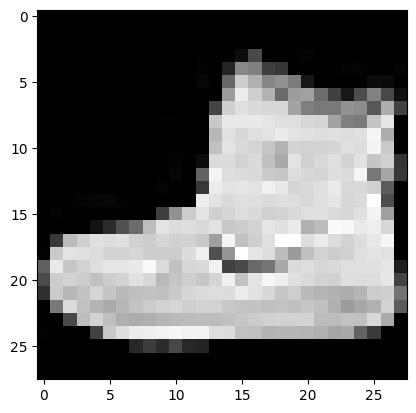

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze(), cmap=plt.cm.gray)

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [67]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's also check the length of the train and test dataloader

In [68]:
print(len(trainDataLoader))
print(len(testDataLoader))

938
157


The length here depends upon the batch size defined above. Multiplying the length of our dataloader by the batch size should give us back the number of samples in each set.

In [69]:
print(len(trainDataLoader) * 64) # batch_size from above
print(len(testDataLoader) * 64)

60032
10048


Now let's use it to look at a few images.

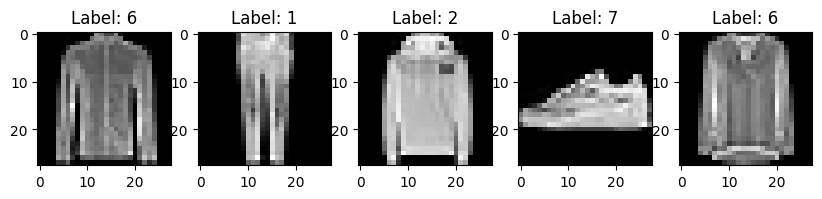

In [70]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

Now let's set up our model.

In [71]:
class DenseNN(torch.nn.Module):
    def __init__(self):
        super(DenseNN, self).__init__()
        self.flatten = torch.nn.Flatten() 
        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),  
            torch.nn.ReLU(),              
            torch.nn.Linear(256, 128),    
            torch.nn.ReLU(),              
            torch.nn.Linear(128, 64),     
            torch.nn.ReLU(),             
            torch.nn.Linear(64, 10)       
        )

    def forward(self, x):
        x = self.flatten(x)          
        x = self.hidden_layers(x)    
        return x


net = DenseNN()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Now let's train our model!

In [72]:
train_loss_history = []
test_loss_history = []

for epoch in range(30):
  train_loss = 0.0
  test_loss = 0.0
  
  net.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images
    labels = labels
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = net(images) # forward propagation  
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  net.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images
      labels = labels
      predicted_output = net(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 1.790800531535769, Test loss 1.0603051542476485
Epoch 1, Train loss 0.8529607821375068, Test loss 0.7733812026537148
Epoch 2, Train loss 0.6769277097256199, Test loss 0.6564493959496736
Epoch 3, Train loss 0.593183401423985, Test loss 0.6243235043659332
Epoch 4, Train loss 0.5381992296941245, Test loss 0.5406382598315075
Epoch 5, Train loss 0.5053155627300236, Test loss 0.5175931903587025
Epoch 6, Train loss 0.4796605160368531, Test loss 0.515896940117429
Epoch 7, Train loss 0.4631439371467399, Test loss 0.48335448552848426
Epoch 8, Train loss 0.4469954495205046, Test loss 0.5000266747869504
Epoch 9, Train loss 0.43423084589019256, Test loss 0.4897563001912111
Epoch 10, Train loss 0.4239746161551872, Test loss 0.45172963049381404
Epoch 11, Train loss 0.4117685082529399, Test loss 0.4470290798859991
Epoch 12, Train loss 0.4025032970506245, Test loss 0.4385752216645866
Epoch 13, Train loss 0.3930039745308697, Test loss 0.4250946553649416
Epoch 14, Train loss 0.3855933

Let's plot our loss by training epoch to see how we did.

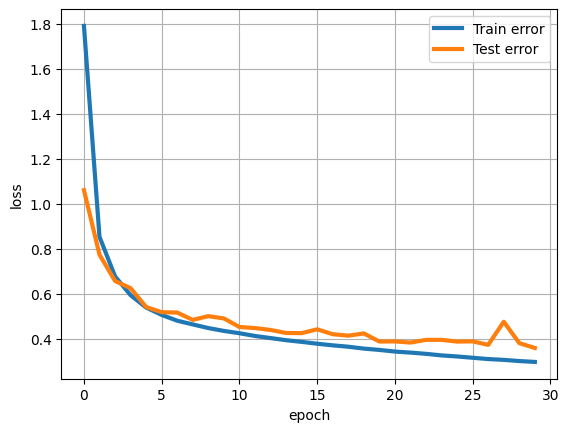

In [73]:
plt.plot(range(30),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(30),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Why is test loss larger than training loss?

We definitely see some improvement. Let's look at the images, the predictions our model makes and the true label.

Now for the labels and predicted labels.

In [74]:
predicted_outputs = net(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
0.11070889979600906


Text(0.5, 1.0, 'Pred: 2, True: 2')

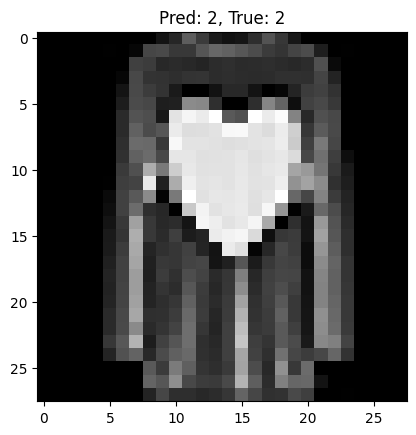

In [75]:
plt.imshow(images[1].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[1].item()}, True: {labels[1].item()}')